This notebook analyzes data from https://github.com/HuthLab/deep-fMRI-dataset. To set up, see instructions in the `deep-fMRI-dataset` folder.

In [1]:
import sys
sys.path.append('..')
import encoding_utils, feature_spaces
viz_cortex = __import__('03_viz_cortex')
calc_resp_PCs = __import__('00_calc_resp_decomp')
from os.path import join
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

# Look at text of input stories

In [ ]:
# Look at narrative stories
train_stories, test_stories, allstories = encoding_utils.get_allstories([1, 2, 3, 4, 5])
wordseqs = feature_spaces.get_story_wordseqs(allstories)
' '.join(wordseqs['sloth'].data)

# Look at responses

In [5]:
train_stories, test_stories, allstories = encoding_utils.get_allstories([1, 2, 3, 4, 5])
subject = 'UTS03'
zRresp = encoding_utils.get_response(train_stories, subject)

In [6]:
zRresp.shape

(9461, 95556)

In [ ]:
viz_cortex.quickshow(zRresp[100])

**Look at PCA stuff**

In [6]:
pca = pkl.load(open(join(calc_resp_PCs.out_dir, 'resps_pca.pkl'), 'rb'))['pca']

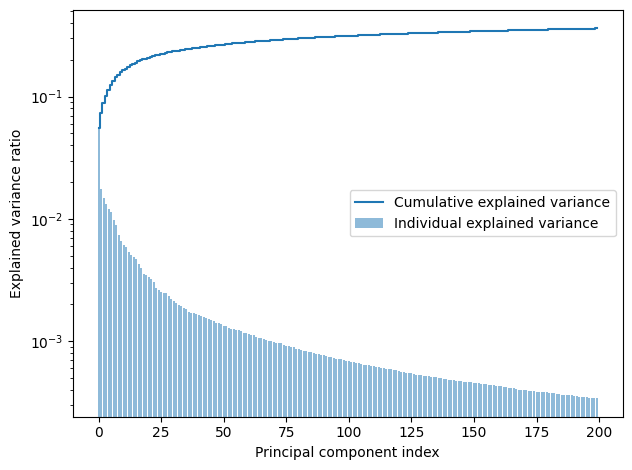

In [10]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
n = 200
plt.bar(range(0, n), exp_var_pca[:n], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, n), cum_sum_eigenvalues[:n], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Skorch setup

In [5]:
import numpy as np
from sklearn.datasets import make_regression
from torch import nn
from skorch.callbacks import EarlyStopping
import torch
from skorch import NeuralNetRegressor

n_features = 2
n_targets = 2
X, y = make_regression(n_samples=10000, n_features=n_features,
                       n_informative=1, random_state=0, n_targets=n_targets)
X = X.astype(np.float32)
y = y.astype(np.float32)
print('shapes', X.shape, y.shape)


class MLP(nn.Module):
    def __init__(self, dim_inputs=n_features, dim_hidden=100, dim_outputs=2, nonlin=nn.ReLU()):
        super(MLP, self).__init__()

        self.dense0 = nn.Linear(dim_inputs, dim_hidden)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(dim_hidden, dim_outputs)
        # self.output = nn.Linear(n_outputs, n_outputs)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        # X = self.dropout(X)
        X = self.dense1(X)
        return X


net = NeuralNetRegressor(
    MLP(dim_inputs=X.shape[1], dim_hidden=100, dim_outputs=y.shape[1]),
    max_epochs=100,
    lr=1e-2,
    callbacks=[EarlyStopping(patience=4)],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    device='cuda',
)

net.fit(X, y)
y_proba = net.predict_proba(X)


shapes (10000, 2) (10000, 2)
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4152.1887     1149.8873  0.1777
      2      295.3387       69.2502  0.1614
      3       60.7532       50.4420  0.1712
      4       44.2820       35.8905  0.1643
      5       31.0207       24.4773  0.1608
      6       20.7560       16.0009  0.1650
      7       13.2094        9.6235  0.1632
      8        8.1146        5.7260  0.1629
      9        4.9479        3.4680  0.1654
     10        3.1389        2.2030  0.1662
     11        2.1362        1.5308  0.1682
     12        1.5852        1.1749  0.1650
     13        1.2601        0.9024  0.1654
     14        1.0304        0.7374  0.1665
     15        0.8833        0.6320  0.1627
     16        0.7576        0.5135  0.1644
     17        0.6600        0.4328  0.1658
     18        0.5700        0.3620  0.1670
     19        0.5042        0.3011  0.1607
     20        0.4375        0.2566  0.1652
   

In [8]:
net.module_.state_dict()

OrderedDict([('dense0.weight',
              tensor([[-7.1479e-01, -1.1367e+00],
                      [-3.0662e-01,  3.6305e-02],
                      [-3.2846e-01, -1.4182e+00],
                      [ 4.4656e-01,  7.4274e-01],
                      [ 6.6130e-01, -1.0274e-01],
                      [-5.3013e-01, -1.4208e+00],
                      [ 1.3862e-01, -1.8134e+00],
                      [ 5.2083e-01,  4.9876e-01],
                      [-4.3094e-01, -9.2892e-01],
                      [ 6.5275e-01,  2.2765e+00],
                      [-1.8948e-01, -3.9848e-01],
                      [ 5.6448e-01,  5.9268e-01],
                      [-6.3156e-01, -3.9197e-01],
                      [-5.4049e-01,  1.1864e+00],
                      [-1.9406e-01, -1.3344e+00],
                      [-4.1825e-01, -1.5454e+00],
                      [-3.9052e-01, -1.5454e-02],
                      [-4.7606e-01,  6.5392e-01],
                      [-8.7014e-01, -2.1636e+00],
                   